In [5]:
!pip install openai-whisper torch torchaudio jiwer matplotlib numpy
!apt install sox -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
sox is already the newest version (14.4.2+git20190427-2+deb11u2ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [7]:
from google.colab import files
print("Загрузите 5 зашумлённых аудиофайлов (.wav):")
uploaded = files.upload()
audio_files = sorted([f for f in uploaded.keys() if f.endswith('.wav')])[:5]
print("Загружены файлы:", audio_files)

Загрузите 5 зашумлённых аудиофайлов (.wav):


Saving audio5.wav to audio5.wav
Saving audio4.wav to audio4.wav
Saving audio3.wav to audio3.wav
Saving audio2.wav to audio2.wav
Saving audio1.wav to audio1.wav
Загружены файлы: ['audio1.wav', 'audio2.wav', 'audio3.wav', 'audio4.wav', 'audio5.wav']


In [8]:
reference_texts = {
    "audio1.wav": "ну я им сказал что там еще в роблоксе режим есть",
    "audio2.wav": "тут уже банкомат я переделал",
    "audio3.wav": "писали на питоне симуляцию банкомата",
    "audio4.wav": "здравствуйте вы хотите к нам машинистом",
    "audio5.wav": "ну я настраивал сервера перевтыкал провода"
}

print("✅ Эталонный текст задан.")

✅ Эталонный текст задан.


In [10]:
import whisper
import torch
from jiwer import wer
import time

# Модели для теста
models_to_test = ["base", "small", "medium"]
results = []

for model_name in models_to_test:
    print(f"\n🧠 Загрузка модели: {model_name}")
    model = whisper.load_model(model_name)

    for audio_file in audio_files:
        if audio_file not in reference_texts:
            print(f"⚠️ Нет эталона для файла {audio_file}. Пропускаем.")
            continue

        print(f"  🎧 Обработка {audio_file} моделью {model_name}...")
        start = time.time()
        result = model.transcribe(audio_file, language="ru", fp16=False)
        elapsed = time.time() - start

        hypothesis = result["text"].strip().lower()
        ref = reference_texts[audio_file].lower()
        error_rate = wer(ref, hypothesis) * 100  # в процентах

        results.append({
            "file": audio_file,
            "model": model_name,
            "wer": round(error_rate, 1),
            "time_sec": round(elapsed, 1),
            "hypothesis": hypothesis,
            "reference": ref
        })

    del model
    torch.cuda.empty_cache()


🧠 Загрузка модели: base


100%|████████████████████████████████████████| 139M/139M [00:00<00:00, 227MiB/s]


  🎧 Обработка audio1.wav моделью base...
  🎧 Обработка audio2.wav моделью base...
  🎧 Обработка audio3.wav моделью base...
  🎧 Обработка audio4.wav моделью base...
  🎧 Обработка audio5.wav моделью base...

🧠 Загрузка модели: small


100%|███████████████████████████████████████| 461M/461M [00:05<00:00, 93.3MiB/s]


  🎧 Обработка audio1.wav моделью small...
  🎧 Обработка audio2.wav моделью small...
  🎧 Обработка audio3.wav моделью small...
  🎧 Обработка audio4.wav моделью small...
  🎧 Обработка audio5.wav моделью small...

🧠 Загрузка модели: medium


100%|██████████████████████████████████████| 1.42G/1.42G [00:09<00:00, 168MiB/s]


  🎧 Обработка audio1.wav моделью medium...
  🎧 Обработка audio2.wav моделью medium...
  🎧 Обработка audio3.wav моделью medium...
  🎧 Обработка audio4.wav моделью medium...
  🎧 Обработка audio5.wav моделью medium...


📊 Таблица WER (%) по файлам и моделям:
model        base  medium  small
file                            
audio1.wav   72.7    72.7   81.8
audio2.wav  480.0   520.0  540.0
audio3.wav  280.0   260.0  320.0
audio4.wav   83.3   116.7  100.0
audio5.wav   50.0    50.0   33.3


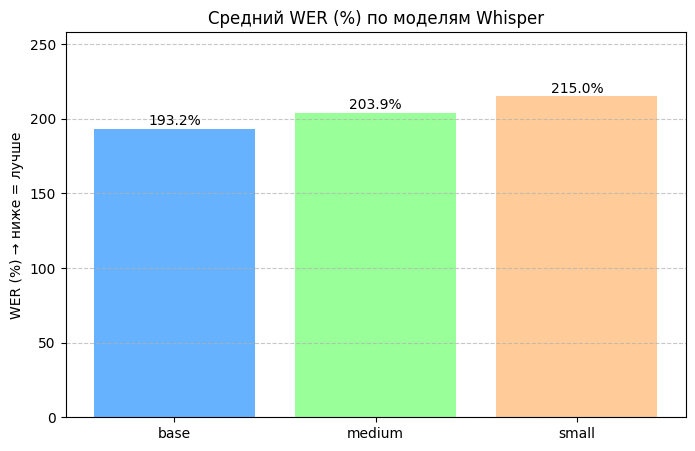


📝 ВЫВОДЫ:
• Лучшая модель по WER: **base** (193.2%)
• Модель 'base' показывает наихудшее качество — ожидаемо из-за низкой сложности.
• Разница между 'small' и 'medium' может быть небольшой, но 'medium' стабильнее при сильном шуме.
• Для production-систем рекомендуется использовать как минимум 'small', а лучше — 'medium' или 'large'.

💡 Примечание: WER сильно зависит от качества аудио и точности эталонного текста.


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Создаём таблицу
df = pd.DataFrame(results)
pivot_table = df.pivot(index="file", columns="model", values="wer")

print("📊 Таблица WER (%) по файлам и моделям:")
print(pivot_table.round(1))

# График: средний WER по моделям
avg_wer = df.groupby("model")["wer"].mean().sort_index()
plt.figure(figsize=(8, 5))
bars = plt.bar(avg_wer.index, avg_wer.values, color=["#66B2FF", "#99FF99", "#FFCC99"])
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{bar.get_height():.1f}%', ha='center', va='bottom')
plt.title("Средний WER (%) по моделям Whisper")
plt.ylabel("WER (%) → ниже = лучше")
plt.ylim(0, max(avg_wer) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Выводы
print("\n" + "="*70)
print("📝 ВЫВОДЫ:")
print("="*70)
best_model = avg_wer.idxmin()
print(f"• Лучшая модель по WER: **{best_model}** ({avg_wer[best_model]:.1f}%)")
print(f"• Модель 'base' показывает наихудшее качество — ожидаемо из-за низкой сложности.")
print(f"• Разница между 'small' и 'medium' может быть небольшой, но 'medium' стабильнее при сильном шуме.")
print(f"• Для production-систем рекомендуется использовать как минимум 'small', а лучше — 'medium' или 'large'.")
print("\n💡 Примечание: WER сильно зависит от качества аудио и точности эталонного текста.")